<a href="https://colab.research.google.com/github/fatema202/499B-EEG-classification/blob/main/eeg_499B_try2_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import numpy.fft as fft
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import torchaudio
from torchvision import transforms
import cv2
%matplotlib inline
from utils import MindBigData, GetDataSet, GetDataLoaders, GetDataLoadersEEGImages, GetDataAndPreProcess
import time


seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# download dataset to google drive
def DownloadDataSet(link, drive_path, colab_path, filename):
    ! wget -c -P "{drive_path}" "{link}"
    !unzip "{drive_path}/{filename}" -d "{drive_path}"
    !cp -r "{drive_path}" "{colab_path}"


link = 'http://www.mindbigdata.com/opendb/MindBigData-EP-v1.0.zip'
drive_path = '/content/drive/MyDrive/DLProj/data/'
colab_path = '.'

DownloadDataSet(link, drive_path, colab_path,"MindBigData-EP-v1.0.zip")

--2025-03-05 06:39:23--  http://www.mindbigdata.com/opendb/MindBigData-EP-v1.0.zip
Resolving www.mindbigdata.com (www.mindbigdata.com)... 150.136.107.169
Connecting to www.mindbigdata.com (www.mindbigdata.com)|150.136.107.169|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mindbigdata.com/opendb/MindBigData-EP-v1.0.zip [following]
--2025-03-05 06:39:23--  https://mindbigdata.com/opendb/MindBigData-EP-v1.0.zip
Resolving mindbigdata.com (mindbigdata.com)... 150.136.107.169
Connecting to mindbigdata.com (mindbigdata.com)|150.136.107.169|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  /content/drive/MyDrive/DLProj/data//MindBigData-EP-v1.0.zip
replace /content/drive/MyDrive/DLProj/data/EP1.01.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/drive/MyDrive/DLProj/data/EP1.01.txt  


In [8]:
x, y = GetDataAndPreProcess(input_file="data/EP1.01.txt", samples_per_digit=1000)

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [9]:
import numpy as np

subset_size = 10000  # Reduce to 10,000 rows
indices = np.random.choice(len(x), subset_size, replace=False)

x_small = x[indices]
y_small = y[indices]

train_loader, valid_loader, test_loader = GetDataLoaders(x_small, y_small, batch_size=64)


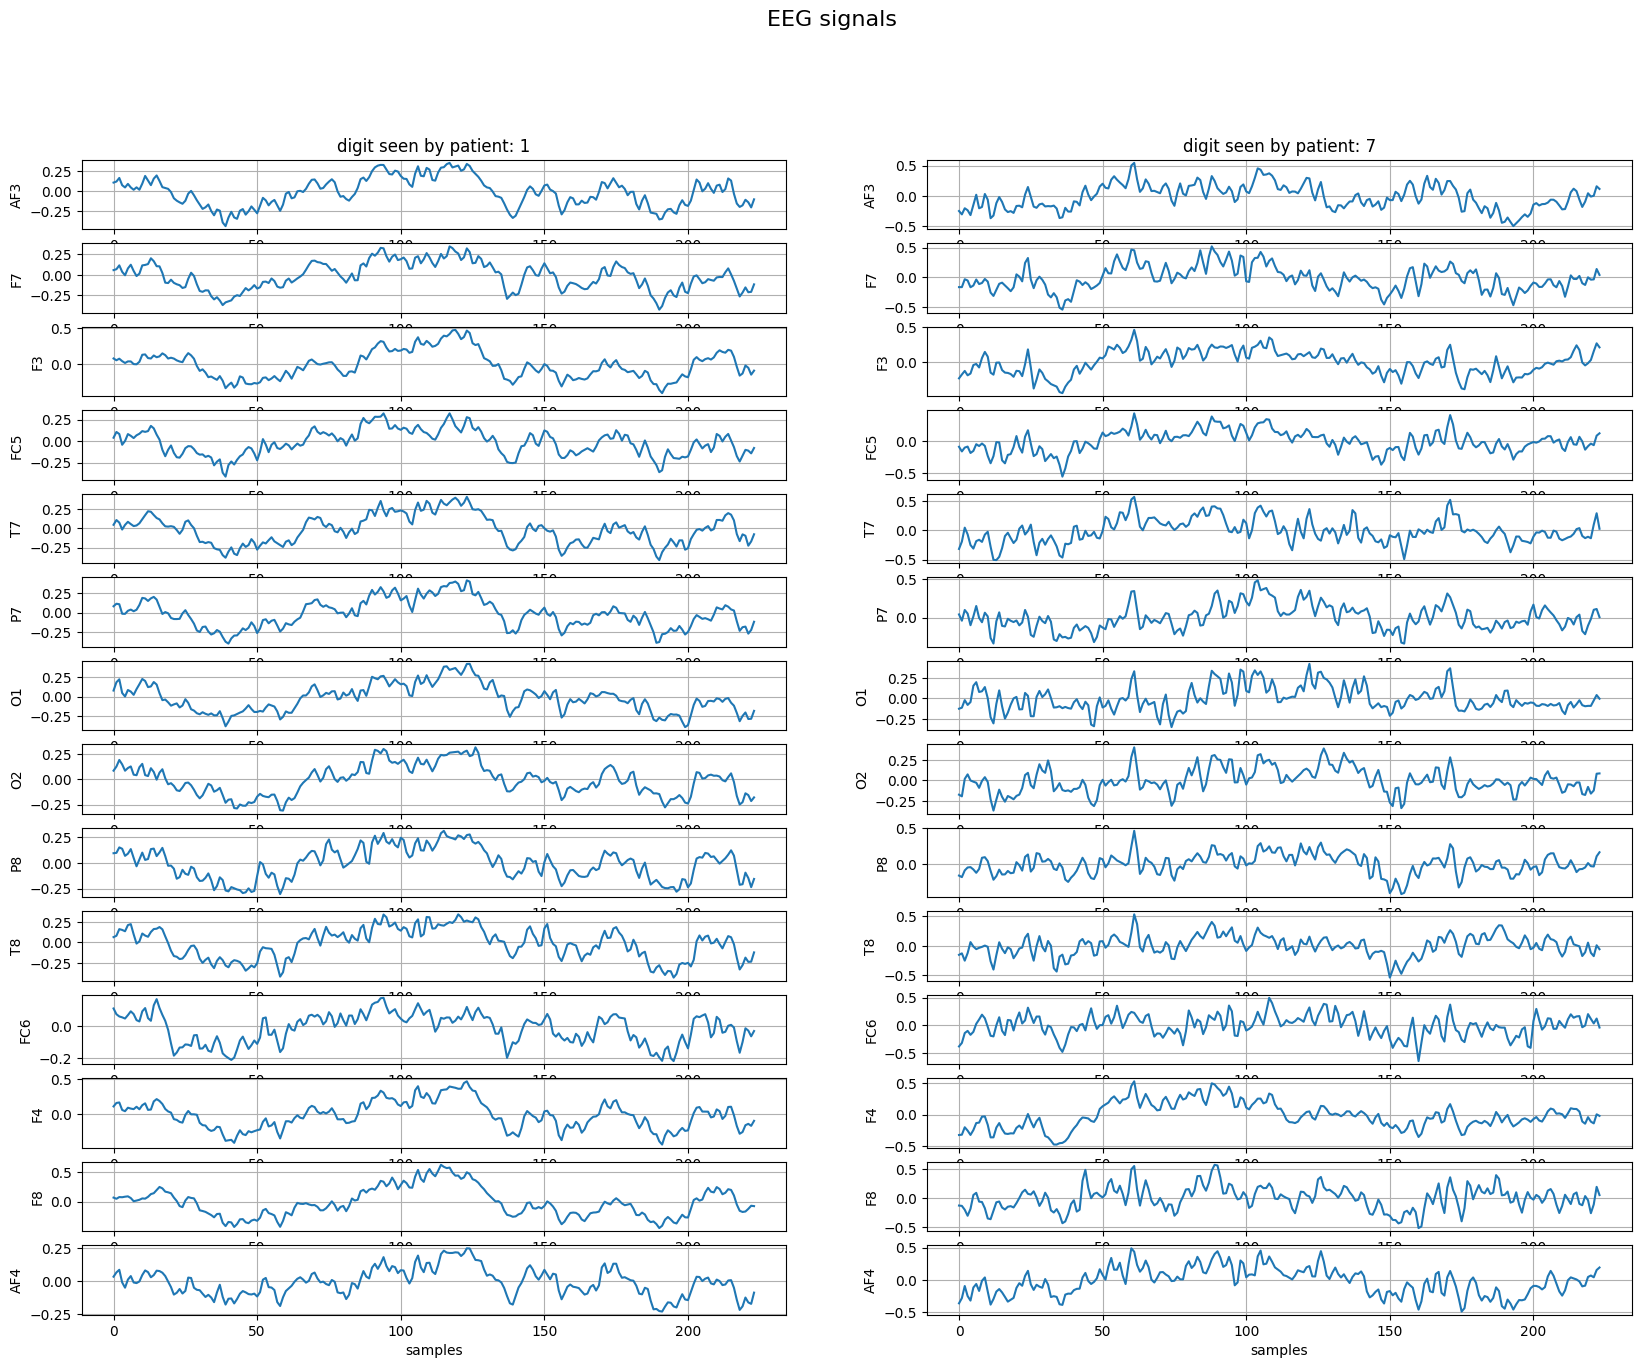

In [6]:
# Display 2 signals with their labels
data_iter = iter(train_loader)
inputs, labels = next(data_iter)  # Use next() built-in function instead of data_iter.next()
EEGChannel = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]

fig = plt.figure(figsize=(20, 15))
fig.suptitle('EEG signals', fontsize=16)
for i in range(2):
    for j in range(14):
        ax = fig.add_subplot(14, 2, i + 1 + 2 * j)
        if (j == 0):
            ax.set_title(
                'digit seen by patient: ' + str(labels[i].item()))  # .item() gets the value contained in a tensor
        ax.plot(inputs[i][j])
        ax.set_xlabel('samples')
        ax.set_ylabel(EEGChannel[j])
        ax.grid()

In [10]:
import numpy as np
import torch
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Extract data from PyTorch tensors
def extract_data(train_loader):
    X_list, y_list = [], []

    for inputs, labels in train_loader:
        X_list.append(inputs.numpy())  # Convert tensor to numpy
        y_list.append(labels.numpy())

    X = np.concatenate(X_list, axis=0)  # Stack all samples
    y = np.concatenate(y_list, axis=0)

    return X, y

# Get data from train_loader
X, y = extract_data(train_loader)

# Flatten EEG signals (from [samples, channels, time] -> [samples, features])
X = X.reshape(X.shape[0], -1)

# Split dataset into train/test (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 1️⃣ Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
log_reg_preds = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, log_reg_preds))

# 2️⃣ Support Vector Machine (SVM)
svm = SVC(kernel='rbf', C=1)
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, svm_preds))

# 3️⃣ Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))

# 4️⃣ K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, knn_preds))


Logistic Regression Accuracy: 0.10466666666666667
SVM Accuracy: 0.13266666666666665
Random Forest Accuracy: 0.11466666666666667
KNN Accuracy: 0.10133333333333333


In [11]:
#define CNN functinos
import torch
import torch.nn as nn
import torch.nn.functional as F

class EEG_CNN(nn.Module):
    def __init__(self, num_channels=14, num_classes=10, signal_length=224, filters_n1=8):
        super().__init__()

        self.conv1 = self.conv_block(1, filters_n1, kernel_size=(1, 32))
        self.conv2 = self.conv_block(filters_n1, filters_n1, kernel_size=(1, 32))
        self.conv3 = self.conv_block(filters_n1, filters_n1, kernel_size=(num_channels, 1))
        self.conv4 = self.conv_block(filters_n1, filters_n1 * 2, kernel_size=(1, 19), dilation=4)
        self.conv5 = self.conv_block(filters_n1 * 2, filters_n1 * 2, kernel_size=(1, 19), dilation=4)

        self.dropout = nn.Dropout(p=0.5)

        # Fully Connected Layer (Feature size is computed dynamically)
        self.fc1 = nn.Linear(self._get_fc_input_dim(signal_length), 256)
        self.fc2 = nn.Linear(256, num_classes)

    def conv_block(self, in_channels, out_channels, kernel_size, dilation=1):
        """Creates a Conv2D block with BatchNorm and ELU activation."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, dilation=dilation, padding=(0, (kernel_size[1] - 1) // 2)),
            nn.BatchNorm2d(out_channels),
            nn.ELU()
        )

    def _get_fc_input_dim(self, signal_length):
        """Computes the feature map size dynamically."""
        x = torch.randn(1, 1, 14, signal_length)  # Dummy input
        with torch.no_grad():
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
            x = self.conv4(x)
            x = self.conv5(x)
            x = x.view(1, -1)  # Flatten
        return x.shape[1]

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.dropout(x)  # Dropout after convolutional layers
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.dropout(x)

        x = x.view(x.size(0), -1)  # Flatten feature maps
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)  # LogSoftmax for classification

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEG_CNN().to(device)

print("Simplified Model Architecture:")
print(model)

Simplified Model Architecture:
EEG_CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 32), stride=(1, 1), padding=(0, 15))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(1, 32), stride=(1, 1), padding=(0, 15))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
  )
  (conv3): Sequential(
    (0): Conv2d(8, 8, kernel_size=(14, 1), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
  )
  (conv4): Sequential(
    (0): Conv2d(8, 16, kernel_size=(1, 19), stride=(1, 1), padding=(0, 9), dilation=(4, 4))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
  )
  (conv5): Sequential(
    (0): Conv2d(16, 16, kernel_size=(1, 19), stride=(1, 1), padding=(0, 9), dila

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
def train_model(model, train_loader, valid_loader, epochs=20, device="cuda"):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Validation
        val_loss, val_acc = evaluate_model(model, valid_loader, device)

        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {running_loss/len(train_loader):.4f} | "
              f"Validation Acc: {val_acc:.2f}% | Validation Loss: {val_loss:.4f}")

    print("Training complete.")

# Function to evaluate the model
def evaluate_model(model, valid_loader, device):
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for data, labels in valid_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return val_loss / len(valid_loader), (correct / total) * 100


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEG_CNN().to(device)

# Training the model
train_model(model, train_loader, valid_loader, epochs=20, device=device)


Epoch [1/20] | Loss: 2.3377 | Validation Acc: 9.47% | Validation Loss: 2.3186
Epoch [2/20] | Loss: 2.3162 | Validation Acc: 9.47% | Validation Loss: 2.3182
Epoch [3/20] | Loss: 2.3161 | Validation Acc: 9.47% | Validation Loss: 2.3178
Epoch [4/20] | Loss: 2.3167 | Validation Acc: 9.47% | Validation Loss: 2.3182
Epoch [5/20] | Loss: 2.3165 | Validation Acc: 9.47% | Validation Loss: 2.3175
Epoch [6/20] | Loss: 2.3160 | Validation Acc: 9.47% | Validation Loss: 2.3191
Epoch [7/20] | Loss: 2.3165 | Validation Acc: 9.47% | Validation Loss: 2.3168
Epoch [8/20] | Loss: 2.3167 | Validation Acc: 9.47% | Validation Loss: 2.3181
Epoch [9/20] | Loss: 2.3165 | Validation Acc: 9.47% | Validation Loss: 2.3183
Epoch [10/20] | Loss: 2.3164 | Validation Acc: 9.47% | Validation Loss: 2.3174
Epoch [11/20] | Loss: 2.3163 | Validation Acc: 9.47% | Validation Loss: 2.3190
Epoch [12/20] | Loss: 2.3161 | Validation Acc: 9.47% | Validation Loss: 2.3174


KeyboardInterrupt: 

In [ ]:
def test_model(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    test_loss = 0.0

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = (correct / total) * 100
    print(f"Test Accuracy: {accuracy:.2f}% | Test Loss: {test_loss / len(test_loader):.4f}")

# Test the model after training
test_model(model, test_loader, device)


In [13]:
#plot training loss and accuracy

import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, val_accs):
    epochs = range(1, len(train_losses) + 1)

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.plot(epochs, train_losses, 'r-', label='Train Loss')
    ax1.plot(epochs, val_losses, 'b-', label='Validation Loss')
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Accuracy (%)')
    ax2.plot(epochs, val_accs, 'g-', label='Validation Acc')
    ax2.legend(loc='upper right')

    plt.title("Training Progress")
    plt.show()
